In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from scipy.stats import normaltest

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns',25)
pd.set_option('display.max_rows',25)

In [4]:
df = pd.read_csv('dataset/train.csv', na_values=['?','Error','Unknown'])
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,NaN,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,NaN,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [5]:
def shape(x):
    row,column = x.shape
    print(f'The dataset has {row} rows and {column} columns.')

In [6]:
shape(df)

The dataset has 36992 rows and 25 columns.


In [7]:
df['churn_risk_score'].value_counts()

 3    10424
 4    10185
 5     9827
 2     2741
 1     2652
-1     1163
Name: churn_risk_score, dtype: int64

`As it is mentioned, the churn_risk_score is in the range of 1 to 5. So we are dropping -1 values as it might alter our prediction`

In [8]:
df = df[df['churn_risk_score']!=-1]

In [9]:
shape(df)

The dataset has 35829 rows and 25 columns.


In [10]:
df['churn_risk_score'].value_counts()

3    10424
4    10185
5     9827
2     2741
1     2652
Name: churn_risk_score, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35829 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   35829 non-null  object 
 1   Name                          35829 non-null  object 
 2   age                           35829 non-null  int64  
 3   gender                        35773 non-null  object 
 4   security_no                   35829 non-null  object 
 5   region_category               30566 non-null  object 
 6   membership_category           35829 non-null  object 
 7   joining_date                  35829 non-null  object 
 8   joined_through_referral       30537 non-null  object 
 9   referral_id                   35829 non-null  object 
 10  preferred_offer_types         35553 non-null  object 
 11  medium_of_operation           30599 non-null  object 
 12  internet_option               35829 non-null  object 
 13  l

In [12]:
#changing joining_date to datetime format
df['joining_date'] = pd.to_datetime(df['joining_date'])

df['joined_days'] = df['joining_date'].apply(lambda x: int(str(pd.to_datetime('now')-x).split()[0]))

In [13]:
def transaction_range(x):
    if x<50000:
        return 0
    else:
        return 1

In [14]:
df['transaction_range'] = df['avg_transaction_value'].apply(transaction_range)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,35829.0,37.120266,15.865360,10.000000,23.0000,37.00,51.0000,64.000000
days_since_last_login,35829.0,-42.143906,229.254856,-999.000000,8.0000,12.00,16.0000,26.000000
avg_time_spent,35829.0,243.373859,397.784650,-2814.109110,59.8100,161.62,356.3300,3235.578521
avg_transaction_value,35829.0,29304.272306,19484.565419,800.460000,14194.6500,27584.53,40874.0100,99914.050000
avg_frequency_login_days,32410.0,15.963040,9.205918,-43.652702,9.0000,16.00,23.0000,73.061995
points_in_wallet,32488.0,686.849231,194.574486,-760.661236,615.9675,697.82,764.0025,2069.069761
churn_risk_score,35829.0,3.608278,1.176426,1.000000,3.0000,4.00,5.0000,5.000000
joined_days,35829.0,1745.496302,317.872079,1201.000000,1469.0000,1744.00,2023.0000,2296.000000
transaction_range,35829.0,0.078428,0.268848,0.000000,0.0000,0.00,0.0000,1.000000


In [16]:
df.describe(include='object').T

,count,unique,top,freq
customer_id,35829,35829,fffe43004900440033003500300034003500,1
Name,35829,35829,Sidney Whistler,1
gender,35773,2,F,17892
security_no,35829,35829,4IRCL57,1
region_category,30566,3,Town,13702
membership_category,35829,6,Basic Membership,7473
joined_through_referral,30537,2,No,15354
referral_id,35829,11120,xxxxxxxx,17296
preferred_offer_types,35553,3,Gift Vouchers/Coupons,11977
medium_of_operation,30599,3,Desktop,13476


In [17]:
#dropping the categorical features with unique values
df.drop(['customer_id','Name','security_no','referral_id','last_visit_time','joining_date'],1,inplace=True)

In [18]:
df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,joined_days,transaction_range
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,NaN,Wi-Fi,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2,1337,1
1,32,F,City,Premium Membership,NaN,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1,1326,0
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5,1616,0
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5,1629,0
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5,1311,0


In [19]:
shape(df)

The dataset has 35829 rows and 21 columns.


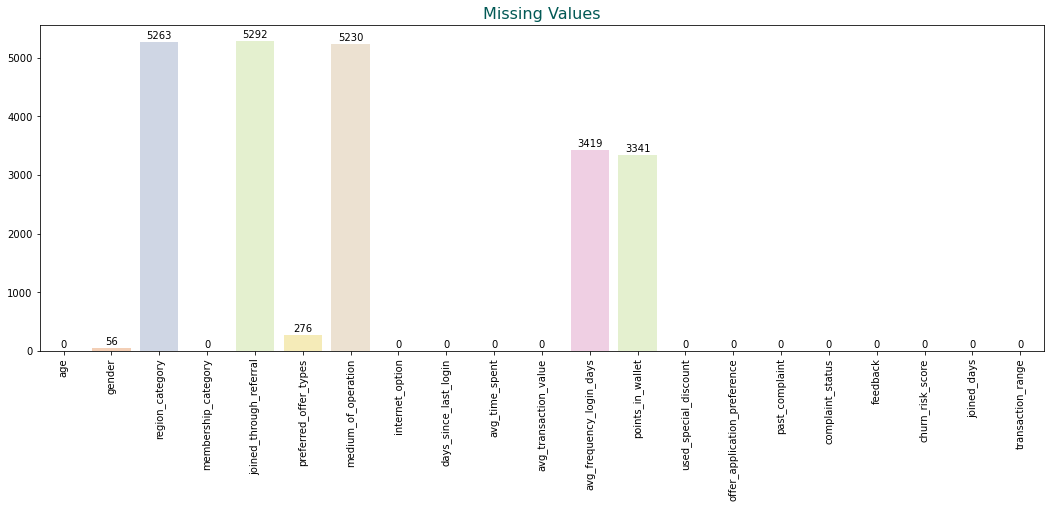

In [20]:
plt.figure(figsize=(18,6))
g = sns.barplot(x=df.columns, y=df.isna().sum(), palette='Pastel2')
plt.xticks(rotation=90)#, color='#822659')
plt.title('Missing Values', size=16, color = '#025955')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+20),ha='center', va='bottom',
               color= 'black')
plt.show()

In [21]:
missing_cols = pd.Series(df.isna().sum().sort_values(ascending=False))
missing_cols = missing_cols[missing_cols != 0]
missing_cols

joined_through_referral     5292
region_category             5263
medium_of_operation         5230
avg_frequency_login_days    3419
points_in_wallet            3341
preferred_offer_types        276
gender                        56
dtype: int64

In [22]:
for col in missing_cols.index:
    if df[col].dtype == 'object':
        print(df[col].value_counts())
        print('-----------------------')

No     15354
Yes    15183
Name: joined_through_referral, dtype: int64
-----------------------
Town       13702
City       12315
Village     4549
Name: region_category, dtype: int64
-----------------------
Desktop       13476
Smartphone    13444
Both           3679
Name: medium_of_operation, dtype: int64
-----------------------
Gift Vouchers/Coupons       11977
Credit/Debit Card Offers    11860
Without Offers              11716
Name: preferred_offer_types, dtype: int64
-----------------------
F    17892
M    17881
Name: gender, dtype: int64
-----------------------


In [23]:
normaltest(df['avg_frequency_login_days'], nan_policy='omit')

NormaltestResult(statistic=1449.5364405259297, pvalue=0.0)

In [24]:
normaltest(df['points_in_wallet'], nan_policy='omit')

NormaltestResult(statistic=3274.119008011402, pvalue=0.0)

`Since both the distribution are not normal, we will impute the missing values with the median value`

In [25]:
#imputing 'gender' with mode
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

In [26]:
for col in missing_cols.index:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

In [27]:
df.isna().sum().sum()

0

In [28]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(pd.crosstab(df[col],df['churn_risk_score']))
        print('=====================================================')

churn_risk_score     1     2     3     4     5
gender                                        
F                 1337  1354  5179  5133  4945
M                 1315  1387  5245  5052  4882
churn_risk_score     1     2     3     4     5
region_category                               
City               890   860  3596  3547  3422
Town              1324  1419  5585  5407  5230
Village            438   462  1243  1231  1175
churn_risk_score       1    2     3     4     5
membership_category                            
Basic Membership       0    0     0  2580  4893
Gold Membership      837  634  2590  2513     0
No Membership          0    0     0  2532  4934
Platinum Membership  899  675  2628     0     0
Premium Membership   916  714  2678     0     0
Silver Membership      0  718  2528  2560     0
churn_risk_score            1     2     3     4     5
joined_through_referral                              
No                       1732  1749  5916  5727  5522
Yes                       920  

<h2 style = 'font-family:verdana; color:#ff7171'><center>----------------------------Exploratory Data Analysis----------------------------<center></h2>

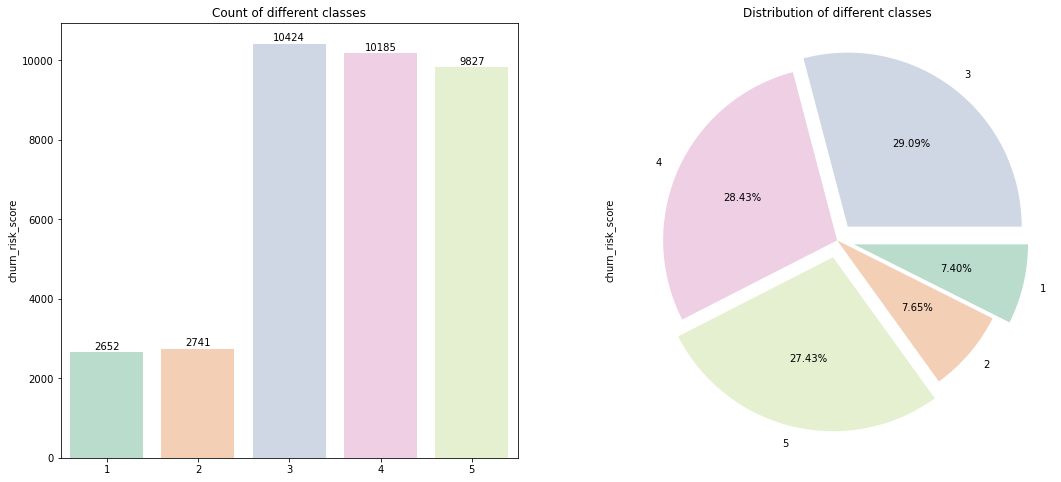

In [29]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
vc = df['churn_risk_score'].value_counts()
g = sns.barplot(x=vc.index,y=vc, palette='Pastel2')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+20),ha='center', va='bottom',
               color= 'black')
plt.title('Count of different classes')
plt.subplot(1,2,2)
colors = ['#CFD6E4', '#EFCFE3', '#E4F0CF', '#F3CFB6', '#B9DCCC']
df['churn_risk_score'].value_counts().plot(kind='pie', explode=[0.1,0,0.1,0,0.1], autopct='%.2f%%', colors=colors)
plt.title('Distribution of different classes')
plt.show()

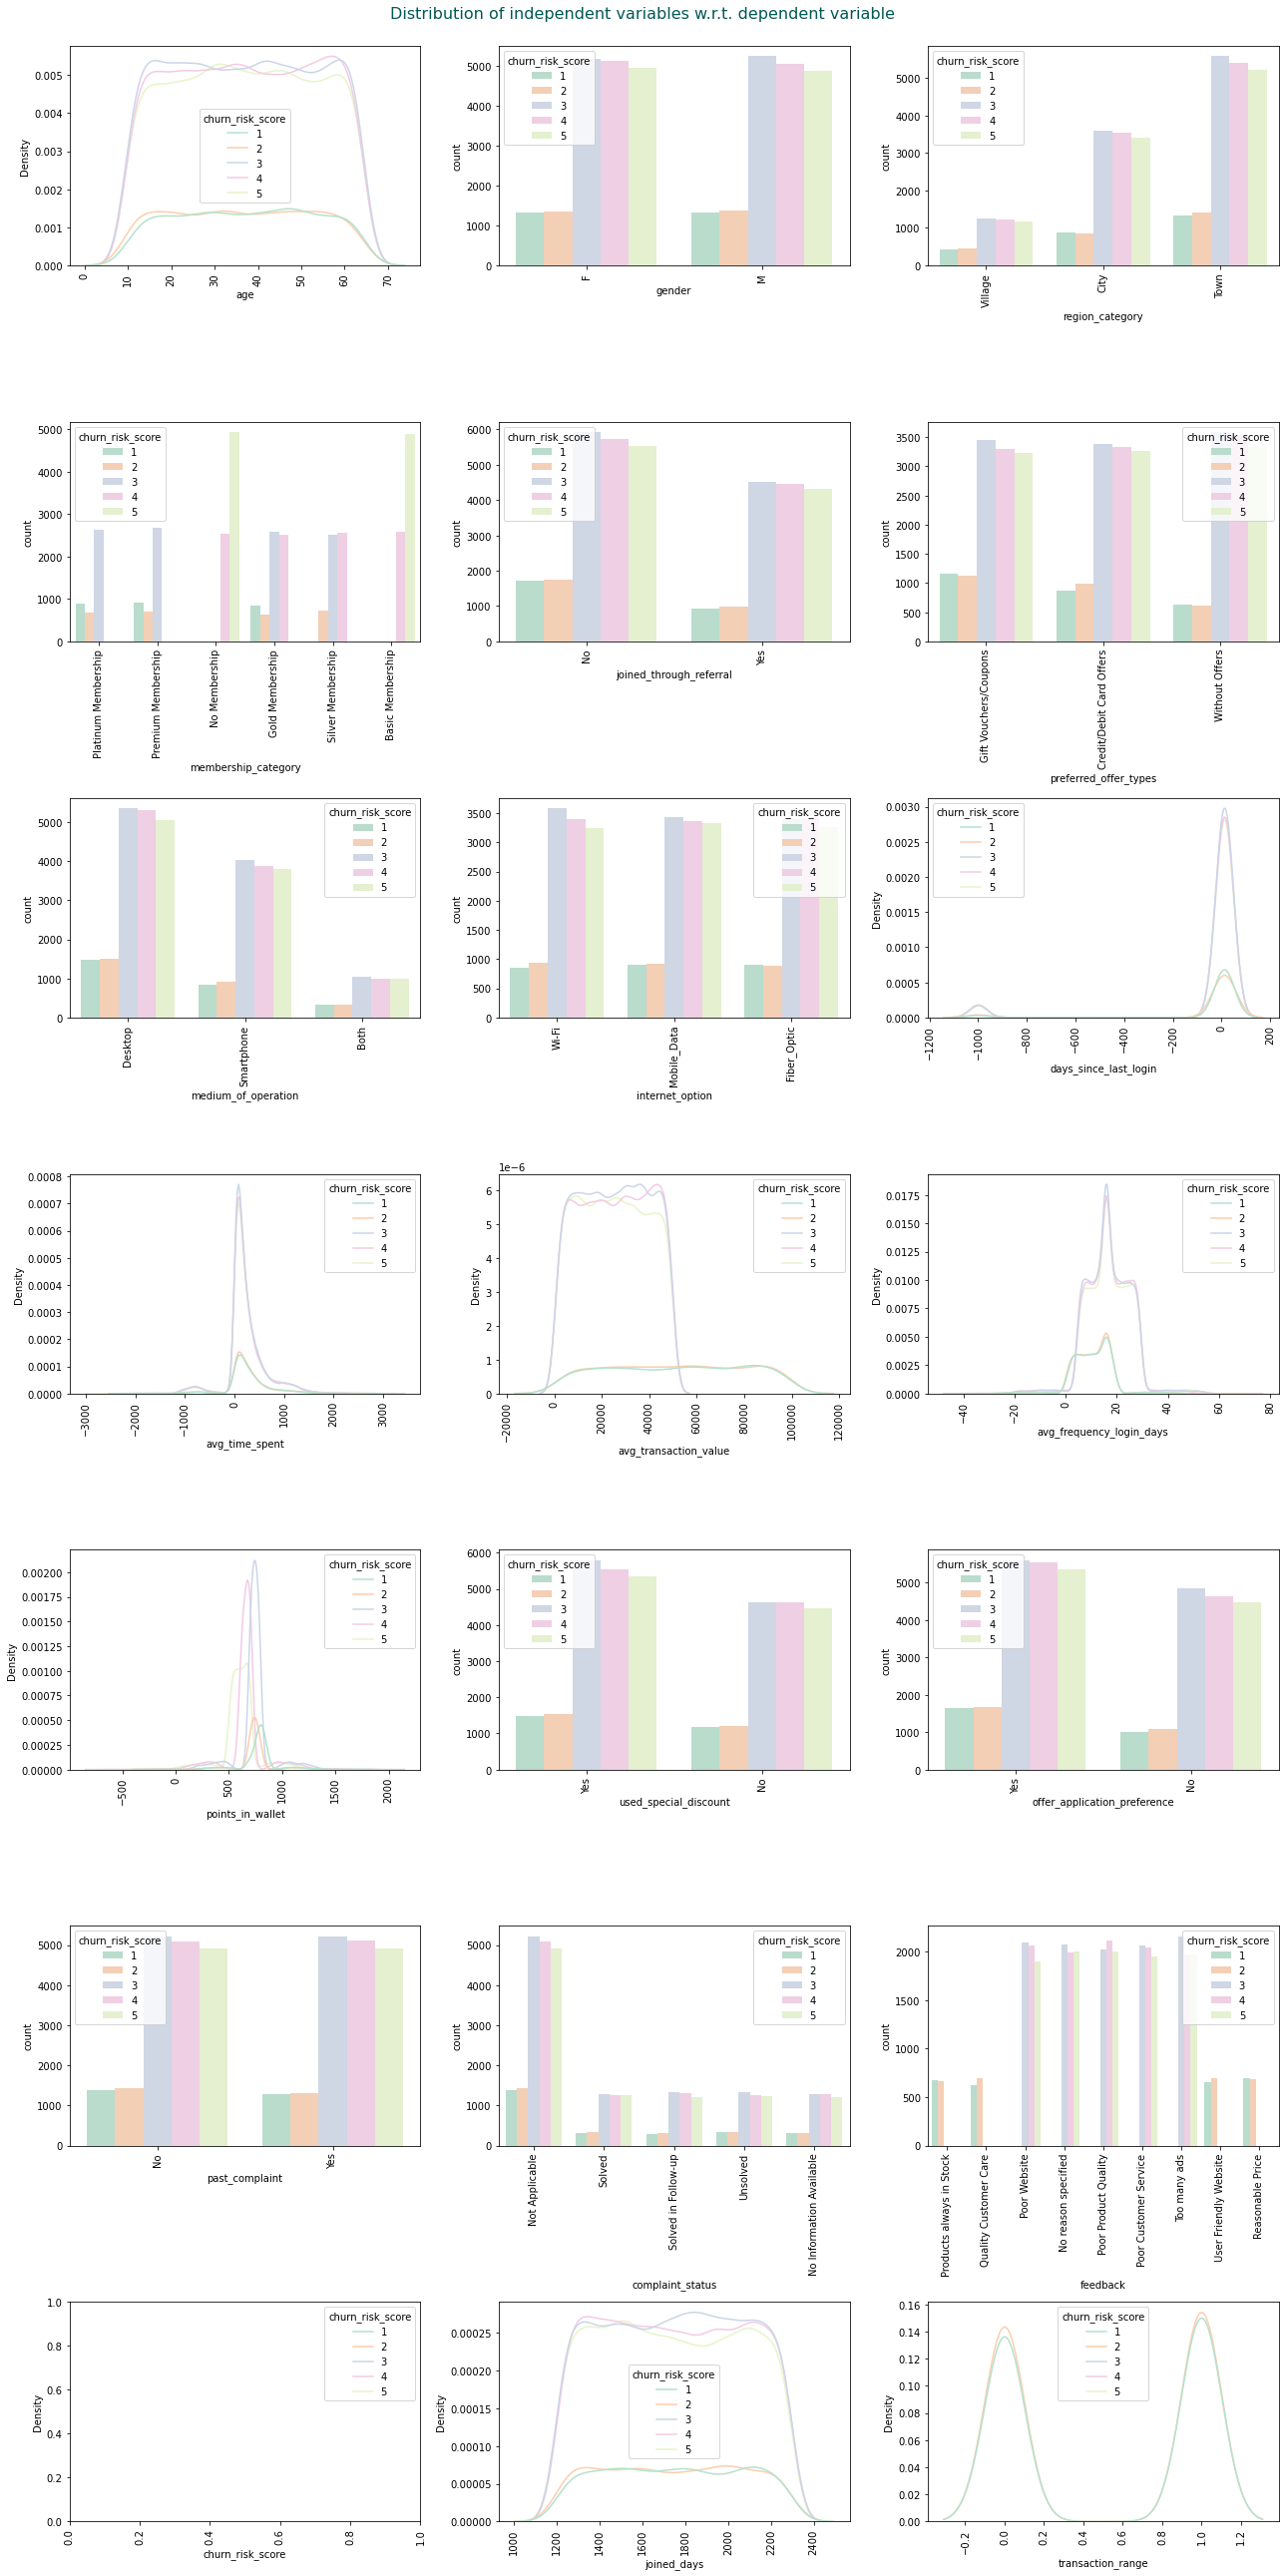

In [33]:
plt.figure(figsize=(18,40))
i = 1
for col in df.columns:
    if col != 'churn_risk_store':
        if df[col].dtype == 'object':
            plt.subplot(8,3,i)
            sns.countplot(x=col, hue='churn_risk_score', data=df, palette='Pastel2')
            i += 1
            plt.xticks(rotation=90)
        elif df[col].dtype in ['float64','int64']:
            plt.subplot(8,3,i)
            sns.kdeplot(x=col, hue='churn_risk_score', data=df, palette='Pastel2')
            i+=1
            plt.xticks(rotation=90)
plt.tight_layout()
plt.suptitle('Distribution of independent variables w.r.t. dependent variable', size=16, color='#025955',y=1.01)
plt.show()

In [37]:
def gender(x):
    return 0 if x == 'F' else 1

def region_category(x):
    return 0 if x=='Village' else 1 if x=='City' else 2 if x=='Town' else 1

def membership_category(x):
    if x =='Platinum Membership':
        return 0
    elif x=='Premium Membership':
        return 1
    elif x=='No Membership':
        return 2
    elif x=='Gold Membership':
        return 3
    elif x =='Silver Membership':
        return 4
    elif x=='Basic Membership':
        return 5
    else:
        return 6
    
def joined_through_referral(x):
    if x=='No':
        return 0
    elif x=='Yes':
        return 1
    else:
        return 2
    
def preferred_offer_types(x):
    if x=='Gift Vouchers/Coupons':
        return 0
    elif x=='Credit/Debit Card Offers':
        return 1
    elif x=='Without Offers':
        return 2
    else:
        return 0
    

def medium_of_operation(x):
    if x=='Desktop':
        return 0
    elif x=='Smartphone':
        return 1
    elif x=='Both':
        return 2
    else:
        return 3
    
def internet_option(x):
    if x=='Wi-Fi':
        return 0
    elif x=='Mobile_Data':
        return 1
    elif x=='Fiber_Optic':
        return 2
    else:
        return 3

def used_special_discount(x):
    if x== 'No':
        return 0
    else:
        return 1
    
def offer_application_preference(x):
    if x=='No':
        return 0
    else:
        return 1
    
def past_complaint(x):
    if x=='No':
        return 0
    else:
        return 1
    
def complaint_status(x):
    if x=='Solved':
        return 0
    elif x=='Solved in Follow-up':
        return 1
    elif x=='Unsolved':
        return 2
    elif x=='No Information Available':
        return 3
    else: return 4
    
def feedback(x):
    if x=='Products always in Stock':
        return 0
    elif x=='Quality Customer Care':
        return 1
    elif x=='Poor Website':
        return 2
    elif x=='No reason specified':
        return 3
    elif x== 'Poor Product Quality':
        return 4
    elif x=='Poor Customer Service':
        return 5
    elif x=='Too many ads':
        return 6
    elif x=='User Friendly Website':
        return 7
    elif x=='Reasonable Price':
        return 8
    else:
        return 9

In [38]:
df1 = df.copy(deep=True)

In [39]:
#label encoding the categorical features
df['gender'] = df['gender'].apply(gender)
df['region_category'] = df['region_category'].apply(region_category)
df['membership_category'] = df['membership_category'].apply(membership_category)
df['joined_through_referral'] = df['joined_through_referral'].apply(joined_through_referral)
df['preferred_offer_types'] = df['preferred_offer_types'].apply(preferred_offer_types)
df['medium_of_operation'] = df['medium_of_operation'].apply(medium_of_operation)
df['internet_option'] = df['internet_option'].apply(internet_option)
df['used_special_discount'] = df['used_special_discount'].apply(used_special_discount)
df['offer_application_preference'] = df['offer_application_preference'].apply(offer_application_preference)
df['past_complaint'] = df['past_complaint'].apply(past_complaint)
df['complaint_status'] = df['complaint_status'].apply(complaint_status)
df['feedback'] = df['feedback'].apply(feedback)

In [40]:
df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,joined_days,transaction_range
0,18,0,0,0,0,0,0,0,17,300.63,53005.25,17.0,781.75,1,1,0,4,0,2,1337,1
1,32,0,1,1,0,0,0,1,16,306.34,12838.38,10.0,697.82,1,0,1,0,1,1,1326,0
2,44,0,2,2,1,0,0,0,14,516.16,21027.00,22.0,500.69,0,1,1,1,2,5,1616,0
3,37,1,1,2,1,0,0,1,11,53.27,25239.56,6.0,567.66,0,1,1,2,2,5,1629,0
4,31,0,1,2,0,1,1,1,20,113.13,24483.66,16.0,663.06,0,1,1,0,2,5,1311,0


In [41]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split

In [42]:
X = df.drop('churn_risk_score',1)
y = df['churn_risk_score']

In [43]:
y = y.map({1:0,2:1,3:2,4:3,5:4})

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
#Standardizing the values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [47]:
sc1 = StandardScaler()
X_sc = sc1.fit_transform(X)
X_sc = pd.DataFrame(X_sc, columns=X.columns)

In [48]:
shape(X_sc)

The dataset has 35829 rows and 20 columns.


In [49]:
from sklearn.metrics import f1_score,classification_report

In [50]:
def model_eval(algo, xtrain, xtest, ytrain, ytest):
    a = algo
    a.fit(xtrain,ytrain)
    ytrain_pred = a.predict(xtrain)
    ytrain_prob = a.predict_proba(xtrain)[:,1]
    ytest_pred = a.predict(xtest)
    ytest_prob = a.predict_proba(xtest)[:,1]
    print('F1 score of Train: ',f1_score(ytrain,ytrain_pred,average='macro'))
    print('----------------------------------')
    print('F1 score of Test: ',f1_score(ytest,ytest_pred,average='macro'))
    print('\n==================================\n')

In [51]:
algos = {'ExtraTrees':ExtraTreesClassifier(),'XGBoost':XGBClassifier(),
         'RandomForest':RandomForestClassifier(),
        'GradientBoost':GradientBoostingClassifier(), 'LGBM':LGBMClassifier()}

In [52]:
for algo in algos:
    print(f'### {algo} ###')
    model_eval(algos[algo],X_train_sc,X_test_sc, y_train,y_test)

### ExtraTrees ###
F1 score of Train:  1.0
----------------------------------
F1 score of Test:  0.697425375035503


### XGBoost ###
F1 score of Train:  0.9733152464400436
----------------------------------
F1 score of Test:  0.7687538571918047


### RandomForest ###
F1 score of Train:  1.0
----------------------------------
F1 score of Test:  0.7667297025454971


### GradientBoost ###
F1 score of Train:  0.8215804356553191
----------------------------------
F1 score of Test:  0.7806963714290582


### LGBM ###
F1 score of Train:  0.9359090789728232
----------------------------------
F1 score of Test:  0.7741264520529985




In [53]:
xgbp = {'learning_rate': 0.8,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 150,
 'reg_alpha': 53,
 'reg_lambda': 42}
rfp = {'max_depth': 9,
 'max_features': 10,
 'min_samples_leaf': 12,
 'min_samples_split': 18,
 'n_estimators': 56}
gbp = {'max_depth': 4,
 'max_features': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 11,
 'n_estimators': 63}

In [54]:
algos1 = {'GradientBoost':GradientBoostingClassifier(**gbp),'XGBoost':XGBClassifier(**xgbp),
         'RandomForest':RandomForestClassifier(**rfp)}

In [55]:
for algo in algos1:
    print(f'### {algo} ###')
    model_eval(algos1[algo],X_train_sc,X_test_sc, y_train,y_test)

### GradientBoost ###
F1 score of Train:  0.8331568965250709
----------------------------------
F1 score of Test:  0.7779326181466724


### XGBoost ###
F1 score of Train:  0.7967110966098438
----------------------------------
F1 score of Test:  0.7795454353006048


### RandomForest ###
F1 score of Train:  0.8278604018989361
----------------------------------
F1 score of Test:  0.7756217434389259




### Test Dataset

In [56]:
test = pd.read_csv('Dataset/test.csv', na_values=['?','Error','Unknown'])
test.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,fffe43004900440031003700300030003400,Alethia Meints,50,F,OQJ1XAY,Village,Premium Membership,2015-11-02,No,xxxxxxxx,Without Offers,Smartphone,Wi-Fi,07:19:30,12,386.26,40721.44,7.0,733.830000,Yes,No,No,Not Applicable,Poor Product Quality
1,fffe43004900440031003900370037003300,Ming Lopez,41,M,OUQRPKO,Village,Gold Membership,2016-03-01,No,xxxxxxxx,Without Offers,Desktop,Fiber_Optic,22:21:16,11,37.80,9644.40,9.0,726.000000,Yes,No,No,Not Applicable,Poor Website
2,fffe43004900440034003800360037003000,Carina Flannigan,31,F,02J2RE7,Town,Silver Membership,2017-03-03,No,xxxxxxxx,Gift Vouchers/Coupons,Both,Mobile_Data,16:40:39,18,215.36,3693.25,21.0,713.780000,Yes,No,Yes,Solved in Follow-up,No reason specified
3,fffe43004900440036003200370033003400,Kyung Wanner,64,M,5YEQIF1,Town,Silver Membership,2017-08-18,Yes,CID8941,Credit/Debit Card Offers,NaN,Fiber_Optic,14:56:17,-999,44.57,36809.56,11.0,744.970000,Yes,No,Yes,No Information Available,Too many ads
4,fffe43004900440035003000370031003900,Enola Gatto,16,F,100RYB5,Town,No Membership,2015-05-05,Yes,CID5690,Without Offers,Smartphone,Mobile_Data,02:57:53,6,349.88,40675.86,8.0,299.048351,No,Yes,Yes,Solved in Follow-up,Poor Website


In [57]:
shape(test)

The dataset has 19919 rows and 24 columns.


In [58]:
id = test['customer_id']

In [59]:
#changing joining_date to datetime format
test['joining_date'] = pd.to_datetime(test['joining_date'])

test['joined_days'] = test['joining_date'].apply(lambda x: int(str(pd.to_datetime('now')-x).split()[0]))

In [60]:
test['transaction_range'] = test['avg_transaction_value'].apply(transaction_range)

In [61]:
#dropping the categorical features with unique values
test.drop(['customer_id','Name','security_no','referral_id','last_visit_time','joining_date'],1,inplace=True)

In [62]:
missing_cols_test = pd.Series(test.isna().sum().sort_values(ascending=False))
missing_cols_test = missing_cols_test[missing_cols_test != 0]
missing_cols_test

joined_through_referral     2998
medium_of_operation         2964
region_category             2948
points_in_wallet            1963
avg_frequency_login_days    1915
preferred_offer_types        159
gender                        36
dtype: int64

In [63]:
#Imputing the missing values:
def missingValImputation(df1, df2, col):
    if df1[col].dtype == 'object':
        df1[col] = df1[col].fillna(df2[col].mode()[0])
    else:
        df1[col] = df1[col].fillna(df2[col].mean())

In [64]:
for col in missing_cols_test.index:
    missingValImputation(test, df1, col)

In [65]:
#label encoding the categorical features
test['gender'] = test['gender'].apply(gender)
test['region_category'] = test['region_category'].apply(region_category)
test['membership_category'] = test['membership_category'].apply(membership_category)
test['joined_through_referral'] = test['joined_through_referral'].apply(joined_through_referral)
test['preferred_offer_types'] = test['preferred_offer_types'].apply(preferred_offer_types)
test['medium_of_operation'] = test['medium_of_operation'].apply(medium_of_operation)
test['internet_option'] = test['internet_option'].apply(internet_option)
test['used_special_discount'] = test['used_special_discount'].apply(used_special_discount)
test['offer_application_preference'] = test['offer_application_preference'].apply(offer_application_preference)
test['past_complaint'] = test['past_complaint'].apply(past_complaint)
test['complaint_status'] = test['complaint_status'].apply(complaint_status)
test['feedback'] = test['feedback'].apply(feedback)

In [66]:
test

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,joined_days,transaction_range
0,50,0,0,1,0,2,1,0,12,386.26,40721.44,7.000000,733.830000,1,0,0,4,4,1991,0
1,41,1,0,3,0,2,0,2,11,37.80,9644.40,9.000000,726.000000,1,0,0,4,2,1871,0
2,31,0,2,4,0,0,2,1,18,215.36,3693.25,21.000000,713.780000,1,0,1,1,3,1504,0
3,64,1,2,4,1,1,0,2,-999,44.57,36809.56,11.000000,744.970000,1,0,1,3,6,1336,0
4,16,0,2,2,1,2,1,1,6,349.88,40675.86,8.000000,299.048351,0,1,1,1,2,2172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19914,12,1,2,3,0,2,0,2,16,103.57,46279.35,18.000000,708.120000,0,1,0,4,4,2272,0
19915,40,0,0,2,1,2,0,2,21,63.19,23466.26,15.966567,574.340000,0,1,0,4,3,1201,0
19916,55,1,2,2,0,1,0,1,18,68.72,17903.75,24.000000,564.300000,0,1,1,2,3,2045,0
19917,17,0,1,4,1,1,1,2,3,119.54,14057.09,22.000000,606.340000,0,1,0,4,2,1824,0


In [67]:
test_sc = sc1.transform(test)
test_sc = pd.DataFrame(test_sc, columns=test.columns)

In [68]:
test_sc.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,joined_days,transaction_range
0,0.811826,-0.998132,-1.994443,-1.083944,-0.857553,1.241155,0.626005,-1.219685,0.236177,0.359210,0.585968,-1.024102,0.248011,0.903920,-1.110357,-0.994850,0.842070,-0.004158,0.772346,-0.291723
1,0.244545,1.001872,-1.994443,0.134995,-0.857553,1.241155,-0.866583,1.230352,0.231815,-0.516804,-1.009011,-0.795675,0.205757,0.903920,-1.110357,-0.994850,0.842070,-1.060746,0.394830,-0.291723
2,-0.385768,-0.998132,0.849975,0.744465,-0.857553,-1.204500,2.118593,0.005334,0.262349,-0.070426,-1.314444,0.574886,0.139811,0.903920,-1.110357,1.005177,-1.186883,-0.532452,-0.759739,-0.291723
3,1.694264,1.001872,0.849975,0.744465,1.166109,0.018328,-0.866583,1.230352,-4.173824,-0.499785,0.385197,-0.567249,0.308128,0.903920,-1.110357,1.005177,0.165752,1.052430,-1.288260,-0.291723
4,-1.331237,-0.998132,0.849975,-0.474474,1.166109,1.241155,0.626005,0.005334,0.210005,0.267752,0.583628,-0.909889,-2.098289,-1.106293,0.900611,1.005177,-1.186883,-1.060746,1.341765,-0.291723


In [69]:
xg = XGBClassifier(**xgbp, max_delta_step=1, n_jobs=-1, subsample=0.99)

In [70]:
xg.fit(X_sc,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8, max_delta_step=1, max_depth=6,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=53,
              reg_lambda=42, scale_pos_weight=None, subsample=0.99,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
res = pd.Series(xg.predict(test_sc))
res

0        2
1        2
2        3
3        2
4        4
        ..
19914    3
19915    4
19916    4
19917    3
19918    2
Length: 19919, dtype: int64

In [72]:
res = res.map({0:1,1:2,2:3,3:4,4:5})

In [73]:
from collections import Counter
Counter(res)

Counter({3: 5465, 4: 4423, 5: 7021, 1: 1954, 2: 1056})

In [150]:
sub = pd.DataFrame({'customer_id':id, 'churn_risk_score':res})

In [151]:
sub.to_csv('Submissions/Submission96.csv', index=False)

***